In [1]:
import pandas as pd
import warnings
import numpy as np
%matplotlib inline
# from matplotlib import pyplot as plt
# from matplotlib import style
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

warnings.filterwarnings(action='ignore', category=DeprecationWarning)

Import all data and merge them.

In [2]:
df_train = pd.read_csv(r'data/train.csv')
df_test = pd.read_csv(r'data/test.csv')
# df_test.info()

In [3]:
df_structure = pd.read_csv(r'data/Building_Structure.csv')
df_ownership = pd.read_csv(r'data/Building_Ownership_Use.csv')

df_train = pd.merge(df_train, df_structure, how='left', left_on='building_id', right_on='building_id')
df_test = pd.merge(df_test, df_structure, how='left', left_on='building_id', right_on='building_id')

df_train = pd.merge(df_train, df_ownership, how='left', left_on='building_id', right_on='building_id')
df_test = pd.merge(df_test, df_ownership, how='left', left_on='building_id', right_on='building_id')

Encode all values to int so that the model can read them.

In [4]:
data = [df_train, df_test]

# LE_condition_post_eq = LE_legal_ownership_status = LE_plan_configuration = LE_position = LE_other_floor_type = LE_ground_floor_type = LE_roof_type = LE_foundation_type = LE_land_surface_condition = LE_area_assesed = LE_damage_grade = preprocessing.LabelEncoder()
LE_condition_post_eq = preprocessing.LabelEncoder()
LE_condition_post_eq.fit(df_train['condition_post_eq'])
LE_legal_ownership_status = preprocessing.LabelEncoder()
LE_legal_ownership_status.fit(df_train['legal_ownership_status'])
LE_plan_configuration = preprocessing.LabelEncoder()
LE_plan_configuration.fit(df_train['plan_configuration'])
LE_position = preprocessing.LabelEncoder()
LE_position.fit(df_train['position'])
LE_other_floor_type = preprocessing.LabelEncoder()
LE_other_floor_type.fit(df_train['other_floor_type'])
LE_ground_floor_type = preprocessing.LabelEncoder()
LE_ground_floor_type.fit(df_train['ground_floor_type'])
LE_roof_type = preprocessing.LabelEncoder()
LE_roof_type.fit(df_train['roof_type'])
LE_foundation_type = preprocessing.LabelEncoder()
LE_foundation_type.fit(df_train['foundation_type'])
LE_land_surface_condition = preprocessing.LabelEncoder()
LE_land_surface_condition.fit(df_train['land_surface_condition'])
LE_area_assesed = preprocessing.LabelEncoder()
LE_area_assesed.fit(df_train['area_assesed'])
LE_damage_grade = preprocessing.LabelEncoder()
LE_damage_grade.fit(df_train['damage_grade'])

for dataset in data:
    dataset['has_geotechnical_risk'] = dataset['has_geotechnical_risk'].astype('int64')
    dataset['count_families'] = dataset['count_families'].fillna(0)
    dataset['count_families'] = dataset['count_families'].astype('int64')
    dataset['has_secondary_use'] = dataset['has_secondary_use'].astype('int64')
    dataset['has_repair_started'] = dataset['has_repair_started'].fillna(0)
    dataset['has_repair_started'] = dataset['has_repair_started'].astype('int64')
    
    dataset['floor_diff'] = dataset['count_floors_pre_eq']-dataset['count_floors_post_eq']
    dataset['height_diff'] = dataset['height_ft_pre_eq']-dataset['height_ft_post_eq']
    
    dataset['condition_post_eq'] = LE_condition_post_eq.transform(dataset['condition_post_eq'])
    dataset['legal_ownership_status'] = LE_legal_ownership_status.transform(dataset['legal_ownership_status'])
    dataset['plan_configuration'] = LE_plan_configuration.transform(dataset['plan_configuration'])
    dataset['position'] = LE_position.transform(dataset['position'])
    dataset['other_floor_type'] = LE_other_floor_type.transform(dataset['other_floor_type'])
    dataset['ground_floor_type'] = LE_ground_floor_type.transform(dataset['ground_floor_type'])
    dataset['roof_type'] = LE_roof_type.transform(dataset['roof_type'])
    dataset['foundation_type'] = LE_foundation_type.transform(dataset['foundation_type'])
    dataset['land_surface_condition'] = LE_land_surface_condition.transform(dataset['land_surface_condition'])
    dataset['area_assesed'] = LE_area_assesed.transform(dataset['area_assesed'])
for dataset in [df_train]:
    dataset['damage_grade'] = LE_damage_grade.transform(dataset['damage_grade'])

Drop a few features which have low importance for RandomForest classifier.

In [5]:
df_train = df_train.drop(['height_ft_pre_eq', 'height_ft_post_eq', 'count_floors_pre_eq', 'count_floors_post_eq', 'has_secondary_use_use_police', 'has_secondary_use_gov_office', 'has_secondary_use_health_post', 'has_secondary_use_industry', 'has_secondary_use_school', 'has_secondary_use_institution', 'has_geotechnical_risk_liquefaction', 'has_geotechnical_risk_other', 'has_secondary_use_other', 'has_secondary_use_rental', 'has_geotechnical_risk_flood', 'has_superstructure_other'], axis=1)
df_test = df_test.drop(['height_ft_pre_eq', 'height_ft_post_eq', 'count_floors_pre_eq', 'count_floors_post_eq', 'has_secondary_use_use_police', 'has_secondary_use_gov_office', 'has_secondary_use_health_post', 'has_secondary_use_industry', 'has_secondary_use_school', 'has_secondary_use_institution', 'has_geotechnical_risk_liquefaction', 'has_geotechnical_risk_other', 'has_secondary_use_other', 'has_secondary_use_rental', 'has_geotechnical_risk_flood', 'has_superstructure_other'], axis=1)

In [13]:
# df_train = df_train.drop(['has_secondary_use_hotel', 'has_geotechnical_risk_rock_fall', 'has_geotechnical_risk_fault_crack', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_stone_flag', 'has_geotechnical_risk_land_settlement', 'has_superstructure_cement_mortar_stone'], axis=1)
# df_test = df_test.drop(['has_secondary_use_hotel', 'has_geotechnical_risk_rock_fall', 'has_geotechnical_risk_fault_crack', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_stone_flag', 'has_geotechnical_risk_land_settlement', 'has_superstructure_cement_mortar_stone'], axis=1)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421175 entries, 0 to 421174
Data columns (total 36 columns):
area_assesed                              421175 non-null int64
building_id                               421175 non-null object
district_id_x                             421175 non-null int64
has_geotechnical_risk                     421175 non-null int64
has_geotechnical_risk_landslide           421175 non-null int64
has_repair_started                        421175 non-null int64
vdcmun_id_x                               421175 non-null int64
district_id_y                             421175 non-null int64
vdcmun_id_y                               421175 non-null int64
ward_id_x                                 421175 non-null int64
age_building                              421175 non-null int64
plinth_area_sq_ft                         421175 non-null int64
land_surface_condition                    421175 non-null int64
foundation_type                           421175 non-nul

Check feature correlations and remove highly correlated features.

In [ ]:
corr_matrix = df_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
# df_train = df_train.drop(to_drop, axis=1)
# df_test = df_test.drop(to_drop, axis=1)

Prepare training and testing sets.

In [14]:
X_train = df_train.drop(["damage_grade", "building_id"], axis=1).copy()
Y_train = df_train["damage_grade"]
X_test  = df_test.drop("building_id", axis=1).copy()

Create training and validation sets from all training data.

In [15]:
x_train , x_test , y_train , y_test = train_test_split(X_train , Y_train, test_size=0.25)

Oversampling the training set because of imbalanced dataset.

In [ ]:
# sm = SMOTE(random_state=12, ratio = 1.0)
# x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

Random hyperparameter grid.

In [ ]:
n_estimators = [1000] # 1000
max_features = ['sqrt'] # sqrt
max_depth = [None] # None
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True] # True

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

Random search training.

In [ ]:
rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

rf_random.fit(x_train, y_train)

rf_random.best_params_

Training and testing the model.

In [16]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=1000, max_features='sqrt')
random_forest.fit(x_train, y_train)

y_pred = random_forest.predict(x_test)

print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average="macro"))
print(precision_score(y_test, y_pred, average="macro"))
print(recall_score(y_test, y_pred, average="macro"))
'''0.75011'''

0.7752071976244294
0.7490924846841519
0.7529570664410477
0.7461745520526909


'0.7512507801107653 : 1000'

Check feature importance in the RandomForest.

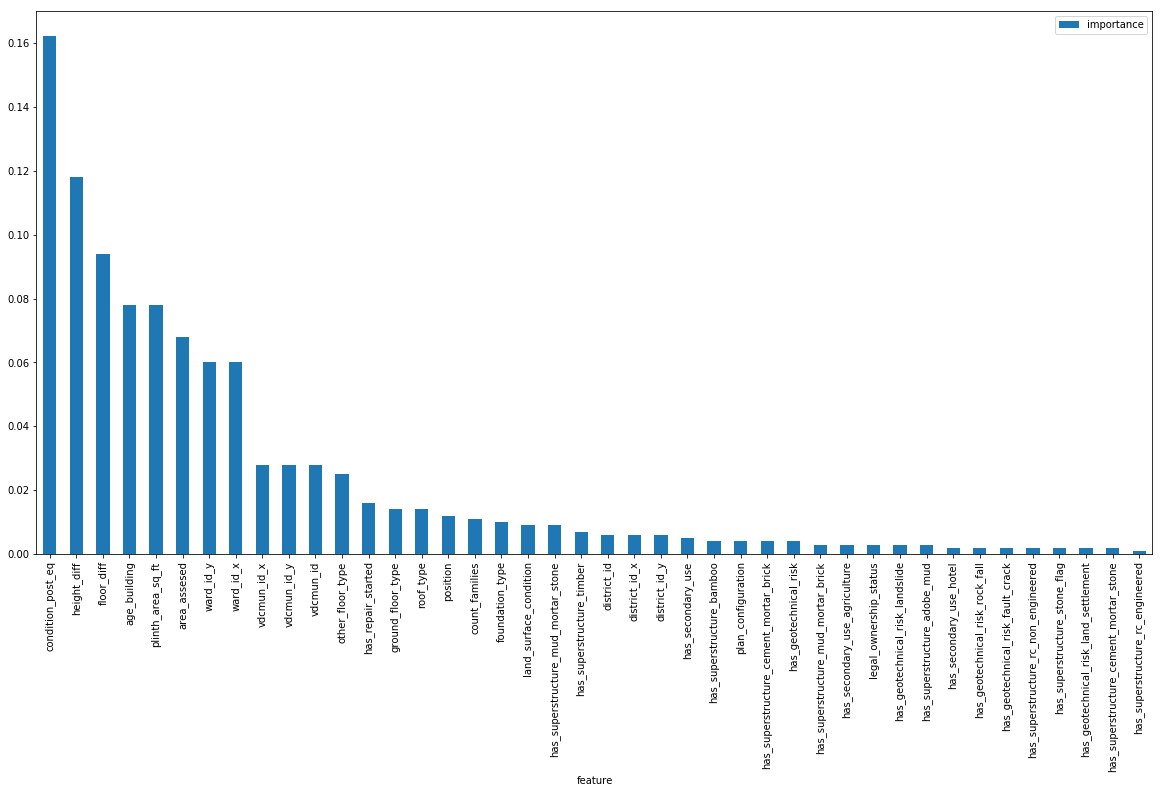

In [10]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar(figsize=(20,10))

Predict damage for test set and save into submission file.

In [12]:
Y_pred = random_forest.predict(X_test)

df_test['damage_grade'] = LE_damage_grade.inverse_transform(Y_pred)
df_test[['building_id' , 'damage_grade']].to_csv('submit_1.csv' , index=False)